# Automated Trading with Backtrader

This is an introduction to the backtrader automated trading system. We decompose the backtrader package into its core components, and explain the very basics of creating your own trading system.

1. **Data Feeds**. The data for the trading strategy needs to be loaded into the backtester needs to be loaded in.
2. **Trading strategy**. The trading strategy is the most complex and involved part of the programming process since this is where decisions are made to buy/sell the asset.
3. **Backtester settings**. Cerebro is the name of the backtester. Cerebro requires several settings such as (i) Trading capital (ii) Broker Comissions (iii) Datafeed (iv) Trading strategy (v) Size of each trading position.
4. **Running backtest**. Run the Cerebro backtester and print out all trades executed.
5. **Evaluating performance**. Graphically evaluate the performance of the backtested trading strategy.

Note: The reference to [0] in an array containing price data refers to the current datapoint and [-1] ([-2])is the first previous datapoint (second previous data point).

### Import modules:

In [7]:
import datetime
import os.path
import sys
import backtrader as bt
import matplotlib.pyplot as plt

### Data:

The datafeed code below reads a local file that is formatted as a Yahoo!Finance CSV file. The data feed can be updated to suit Google Finance data feeds or any other files of the asset returns that you have.

In [9]:
homepath = os.getenv('HOME')
# datapath = os.path.join(homepath, 'github/backtrader/datas/orcl-1995-2014.txt')

data = bt.feeds.YahooFinanceCSVData(
    dataname="orcl-1995-2014.txt",
    fromdate=datetime.datetime(2000,1,1),
    todate = datetime.datetime(2000,12,31),
    reverse=False)

### Strategy Class:

The trading strategy class code contains important parameters and functions for executing the strategy. Important aspects of the Strategy class are as follows:

1. params - This allows you to easily change the values of any variables/parameters in your trading strategy, rather than going into the guts of the code itself.  
2. log - This is a logging function for your strategy. It will print out the datetime and the txt variable provided for the function.  
3. init - This is the code for initializing the class instance of the trading strategy.  
4. notify_order - This keeps track of the status of any orders. Orders have states such as being submitted, accepted, buy/sell execution & price, cancelled/rejected.  
5. notify_trade - This keeps track of the status of any trades. Any trade that is closed will have the gross & net profit reported.  
6. next - This is where the trading strategy is actually programmed. The next command refers to when we step into the next trading bar/window, it performs the checks to see   
    a. Is an order pending?    
  `If an order is pending, then we break out of the function.`  
    b. No order is pending, so are do we have any open positions (i.e., are we in the market?)  
  `i. We have **no open positions**, thus, we check if *buy* conditions are triggered.`   
  `ii. We have **open positions**, thus, we check if the *sell* conditions are triggered.`

The trading strategy below is as follows:

Buy signal - Purchase the asset when the its closing price is 2 bars down in a row.
Sell signal - Liquidate the position after the asset is held for 5 bars. In this case, each bar is a day, but it can be a minute/hour/week/any time period.

In [10]:
class Strat1_2BD_5BH(bt.Strategy):
    
    def __init__(self):
        self.dataclose= self.datas[0].close    # Keep a reference to the "close" line in the data[0] dataseries
        self.order = None # Property to keep track of pending orders.  There are no orders when the strategy is initialized.
        self.buyprice = None
        self.buycomm = None
    
    
    def log(self, txt, dt=None):
        # Logging function for the strategy.  'txt' is the statement and 'dt' can be used to specify a specific datetime
        dt = dt or self.datas[0].datetime.date(0)
        print('{0},{1}'.format(dt.isoformat(),txt))
    
    def notify_order(self, order):
        # 1. If order is submitted/accepted, do nothing 
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 2. If order is buy/sell executed, report price executed
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log('BUY EXECUTED, Price: {0:8.2f}, Cost: {1:8.2f}, Comm: {2:8.2f}'.format(
                    order.executed.price,
                    order.executed.value,
                    order.executed.comm))
                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log('SELL EXECUTED, {0:8.2f}, Cost: {1:8.2f}, Comm{2:8.2f}'.format(
                    order.executed.price, 
                    order.executed.value,
                    order.executed.comm))
            
            self.bar_executed = len(self) #when was trade executed
        # 3. If order is cancelled/margin/rejected, report order canceled
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        self.order = None
    
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        
        self.log('OPERATION PROFIT, GROSS {0:8.2f}, NET {1:8.2f}'.format(
            trade.pnl, trade.pnlcomm))
    
    def next(self):
        # Log the closing prices of the series from the reference
        self.log('Close, {0:8.2f}'.format(self.dataclose[0]))

        if self.order: # check if order is pending, if so, then break out
            return
                
        # since there is no order pending, are we in the market?    
        if not self.position: # not in the market
            if self.dataclose[0] < self.dataclose[-1]:
                if self.dataclose[-1] < self.dataclose[-2]:
                    self.log('BUY CREATE {0:8.2f}'.format(self.dataclose[0]))
                    self.order = self.buy()           
        else: # in the market
            if len(self) >= (self.bar_executed+5):
                self.log('SELL CREATE, {0:8.2f}'.format(self.dataclose[0]))
                self.order = self.sell()

### Backtest settings:

The backtester is known as Cerebro and requires several settings as follows:

1. _Add trading strategy_ - It is necessary to addstrategies into the backtester so it can start testing the performance of the system.  
2. _Data_ - Data needs to be added to the backtester so it can implement the trading strategy on it.  
3. _Broker settings_ - Broker settings such as the amount of trading capital and the trading comissions are required to provide an indication of the gross and net wealth accumulated when executing the trading strategy.  
4. _Position sizing_ - Sets the size of the trades taken as part of the strategy.  

In [11]:
cerebro = bt.Cerebro()  # We initialize the `cerebro` backtester.
cerebro.adddata(data) # We add the dataset in the Data cell.
cerebro.addstrategy(Strat1_2BD_5BH) # We add the strategy described in the `Strategy class` cell
cerebro.broker.setcash(100000.0) # We set an initial trading capital of $100,000
cerebro.broker.setcommission(commission=0.001) # We set broker comissions of 0.1%

### Run backtest
We can see from below that the Buy signal is that Buy orders are created after the closing price is down twice in a row, and that the Sell signal is triggered only after 5 trading days (i.e, Buy is on 2000-01-06, and Sell is on 2000-01-13)

In [12]:
print('Starting Portfolio Value: {0:8.2f}'.format(cerebro.broker.getvalue()))
cerebro.run()
print('Final Portfolio Value: {0:8.2f}'.format(cerebro.broker.getvalue()))

Starting Portfolio Value: 100000.00
2000-01-03,Close,    26.27
2000-01-04,Close,    23.95
2000-01-05,Close,    22.68
2000-01-05,BUY CREATE    22.68
2000-01-06,BUY EXECUTED, Price:    22.27, Cost:    22.27, Comm:     0.02
2000-01-06,Close,    21.35
2000-01-07,Close,    22.99
2000-01-10,Close,    25.74
2000-01-11,Close,    24.99
2000-01-12,Close,    23.49
2000-01-13,Close,    23.36
2000-01-13,SELL CREATE,    23.36
2000-01-14,SELL EXECUTED,    24.24, Cost:    22.27, Comm    0.02
2000-01-14,OPERATION PROFIT, GROSS     1.97, NET     1.92
2000-01-14,Close,    23.75
2000-01-18,Close,    24.74
2000-01-19,Close,    25.41
2000-01-20,Close,    26.35
2000-01-21,Close,    26.55
2000-01-24,Close,    24.10
2000-01-25,Close,    25.10
2000-01-26,Close,    24.49
2000-01-27,Close,    23.04
2000-01-27,BUY CREATE    23.04
2000-01-28,BUY EXECUTED, Price:    22.90, Cost:    22.90, Comm:     0.02
2000-01-28,Close,    21.07
2000-01-31,Close,    22.22
2000-02-01,Close,    24.02
2000-02-02,Close,    24.16
2000-0

### Plot backtest results
We see x3 separate graphs in the figure plotted by `cerebro`.

1. __Wealth accumulation__. We can see the accumulation/loss of wealth over the data period that the trading strategy is implemented.
2. __Trade Gain/Loss__. The blue (red) dots indicate profitable (losing) trades and how much was gained (lost).
3. __Price chart__. The green and red arrows show the entry and exit points, respectively of the trading strategy. The black line is the price of the asset over time. The bars indicate the trading volume of the asset during each bar.

<IPython.core.display.Javascript object>


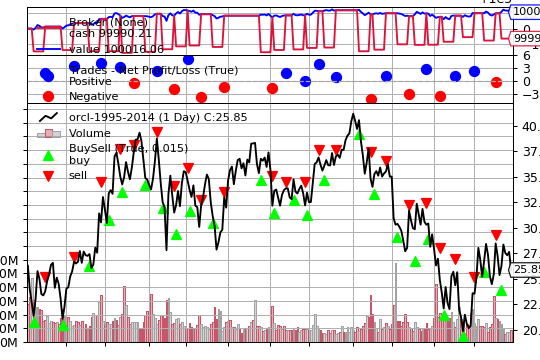

[[<Figure size 432x288 with 4 Axes>]]

In [14]:
%matplotlib inline
cerebro.plot()

### Conclusion
In this post, we learnt the basics of using the `backtester` package with `cerebro`. We performed the following:

1. Added a datafeed from a local CSV file that has price information stored in Yahoo!Finance format.
2. Created a trading strategy that has a Buy signal when the closing price is down 2 days in a row, with a Sell signal when the position is held for more than 5 days.
3. Set a broker commission for each trade tobe 0.1%.
4. Run the backtester and printed out details on all executed trading positions (i.e., buy/sell price, gross and net profits).
5. Printed out the initial and final portfolio value.

In the next post, we will look at the following:

1. _Creating a tuple to easily alter static parameters in our trading strategy_. For example, for the sell signal, the code currently requires us to change the number of days that the position is held in the `next` function in the Strategy class.
2. _Change the position size of each trade_. Currently, the default of 1 unit is used as the position size of each trade. We can change this to a fixed unit/variable dollar/percentage amount.

The below code needs to be run to execute `cerebro.plot()` successfully

<IPython.core.display.Javascript object>


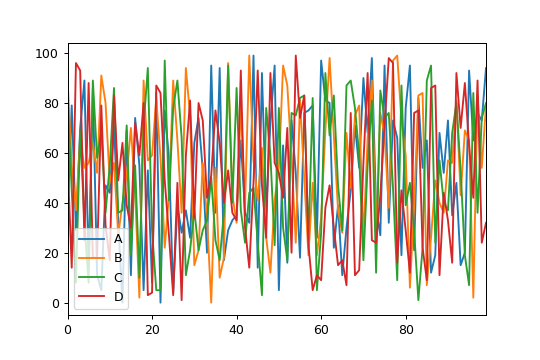

In [15]:
import numpy as np
import pandas as pd

df = pd.DataFrame(np.random.randint(0,100,size=(100,4)),columns = list('ABCD'))
df.head()
df.plot()

# End